# Libraries

In [5]:
!pip install matplotlib numpy
!python -m pip install pyopencl
!python -m pip install pyopencl[pocl]
import pyopencl as cl
import pyopencl.array as cl_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Input

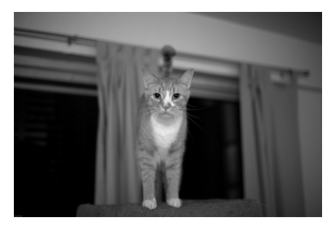

In [6]:
#Definitions of the size of the matrix and the number of iterations to run
P = ['EV','EH',['ROT', 300, 300, 56.3], ['ROT', 0, 300, 90.0]]

img = Image.open("input.png")
data = np.asarray(img)

fig, ax = plt.subplots()
ax.imshow(data,cmap='gray')
plt.axis('off')
plt.show()

# Kernel Code

In [7]:
kernel_code ="""
    __kernel  void image_rotate(    
        __global uchar * src, 
        __global uchar * dest 
        //Data in global memory
        int W, 
        int H,              
        //Image Dimensions
        float sinTita, 
        float cosTita )                    
        //Rotation Parameters
    {    
        const int x = get_global_id(0); 
        const int y = get_global_id(1);    

        int xc = W/2;
        int yc = H/2;

        int xpos =  (x-xc) * cosTita - (y-yc) * sinTita + xc;    
        int ypos =  (x-xc) * sinTita + (y-yc) * cosTita + yc; 

        if ((xpos>=0) && (xpos< W)  && (ypos>=0) && (ypos< H))
        {
            dest_data[ypos * W + xpos] = src_data[y * W + x]; 
        }
    }
"""

# Kernel Settings

In [8]:
N = 2048

#Get platform
platform_list = cl.get_platforms()

# Get devices
devices = platform_list[0].get_devices(device_type = cl.device_type.GPU)

# Create context
context = cl.Context(devices=devices)

# Create command queue
queue = cl.CommandQueue(context)

# Create and intiailize input vectors
a_np = np.arange(N.astype(np.float32))
b_np = np.arange(N.astype(np.float32))

# Create and initialize output vector
res_np = np.empty_like(a_np)

# Create and initialize buffers 
a_g = cl.Buffer(context,cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = a_np)
b_g = cl.Buffer(context,cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = a_np)

#Create output buffer
res_g = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, res_np.nbytes)

#Create program
program = cl.Program(context,kernel_code).build()

kernel = program.image_rotate

#Set arguments
kernel.set_args(a_g,b_g,res_g)

#Define indexed space
globalRange = res_g.np_shape
localRange = None

# Ejecutar el kernel
ev = cl.enqueue_nd_range_kernel(queue,kernel,globalRange,localRange)

# Copy result from device to host
cl.enqueue_copy(queue,res_np,res_g)

print(res_np)

LogicError: clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR